In [ ]:
# INSTALL & IMPORT
import os, re, json, zipfile
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from transformers import AutoTokenizer, TFBertModel, logging as hf_logging
from tensorflow.keras.layers import Input, Dense, Dropout, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

hf_logging.set_verbosity_error()
print(" All libraries are installed and imported successfully.")

 All libraries are installed and imported successfully.


In [ ]:
# LOAD & PREPARE DATA
print("\n Loading and Preprocessing Data ")
from google.colab import files

print("Please upload the 'archive.zip' file.")
uploaded = files.upload()
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')

fake_df = pd.read_csv('/content/data/Fake.csv')
true_df = pd.read_csv('/content/data/True.csv')

def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', str(text))
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Same leakage fix you used in training
true_df['text'] = true_df['text'].astype(str).apply(lambda x: x.split(' - ', 1)[-1])

fake_df['label'] = 1
true_df['label'] = 0

df = pd.concat([fake_df, true_df]).sample(frac=1, random_state=42).reset_index(drop=True)
df['content'] = (df['title'].astype(str) + ' ' + df['text'].astype(str)).apply(clean_text)
df = df[['content', 'label']]

X_train, X_temp, Y_train, Y_temp = train_test_split(
    df['content'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp
)
print(f"Test data size: {len(X_test)}")


 Loading and Preprocessing Data 
Please upload the 'archive.zip' file.


Saving archive.zip to archive.zip
Test data size: 4490


In [ ]:
# REBUILD MODEL & LOAD WEIGHTS
print("\n Loading Tokenizer, Rebuilding Model, and Loading Weights ")

import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Dense, Dropout
from tensorflow.keras.models import Model
from transformers import BertTokenizer, TFBertModel, AutoTokenizer
from google.colab import drive
from pathlib import Path
import json

# Mount Drive
drive.mount('/content/drive')
ARTIFACTS_DIR = Path("/content/drive/MyDrive/fake_news_models/Latest_Bert")
print(f"Attempting to load artifacts from: {ARTIFACTS_DIR}")

# Define parameters
MODEL_NAME = 'bert-base-uncased'
MAX_LEN = 128
THRESHOLD = 0.5
print("-> Config parameters defined manually.")

# Load Tokenizer
tokenizer_dir = ARTIFACTS_DIR / "tokenizer"
if not tokenizer_dir.exists():
    raise FileNotFoundError(f"Tokenizer directory not found at {tokenizer_dir}")
tokenizer = AutoTokenizer.from_pretrained(str(tokenizer_dir))
print("-> Tokenizer loaded successfully.")

# Rebuild the model architecture
class BertLayer(Layer):
    def __init__(self, bert_model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = bert_model
    def call(self, inputs):
        return self.bert(inputs)[1]

def create_classification_model(bert_model, maxlen=MAX_LEN):
    input_ids = Input(shape=(maxlen,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(maxlen,), dtype=tf.int32, name="attention_mask")
    base_bert_model = TFBertModel.from_pretrained('bert-base-uncased', from_pt=True)
    bert_layer = BertLayer(base_bert_model)
    pooled_output = bert_layer({'input_ids': input_ids, 'attention_mask': attention_mask})
    x = Dropout(0.5)(pooled_output)
    x = Dense(64, activation="tanh")(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation="sigmoid", name="classification")(x)
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    return model

# Instantiate the model
model = create_classification_model(MODEL_NAME, MAX_LEN)

# Load the saved weights into the model structure
weights_path = ARTIFACTS_DIR / "fake_news_classifier.weights.h5"
if not weights_path.exists():
    raise FileNotFoundError(f"Model weights file not found at {weights_path}")

model.load_weights(str(weights_path))
print(f"-> Weights loaded successfully from: {weights_path}")

print("\n--- Model Reload Summary ---")
print(f"   Backbone:  {MODEL_NAME}")
print(f"   Max Length: {MAX_LEN}")
print(f"   Threshold:  {THRESHOLD}")
model.summary()


--- Section 2: Loading Tokenizer, Rebuilding Model, and Loading Weights ---
Mounted at /content/drive
Attempting to load artifacts from: /content/drive/MyDrive/fake_news_models/Latest_Bert
-> Config parameters defined manually.
-> Tokenizer loaded successfully.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

-> Weights loaded successfully from: /content/drive/MyDrive/fake_news_models/Latest_Bert/fake_news_classifier.weights.h5

--- Model Reload Summary ---
   Backbone:  bert-base-uncased
   Max Length: 128
   Threshold:  0.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_layer          │ (None, 768)       │          0 │ attention_mask[0… │
│ (BertLayer)         │                   │            │ input_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 768)       │          0 │ bert_layer[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     49,216 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 1)         │         65 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 49,281 (192.50 KB)

 Trainable params: 49,281 (192.50 KB)

 Non-trainable params: 0 (0.00 B)

141/141 ━━━━━━━━━━━━━━━━━━━━ 44s 277ms/step

Classification Report (Test):
              precision    recall  f1-score   support

    Real (0)       0.89      0.84      0.86      2142
    Fake (1)       0.86      0.91      0.88      2348

    accuracy                           0.87      4490
   macro avg       0.88      0.87      0.87      4490
weighted avg       0.88      0.87      0.87      4490



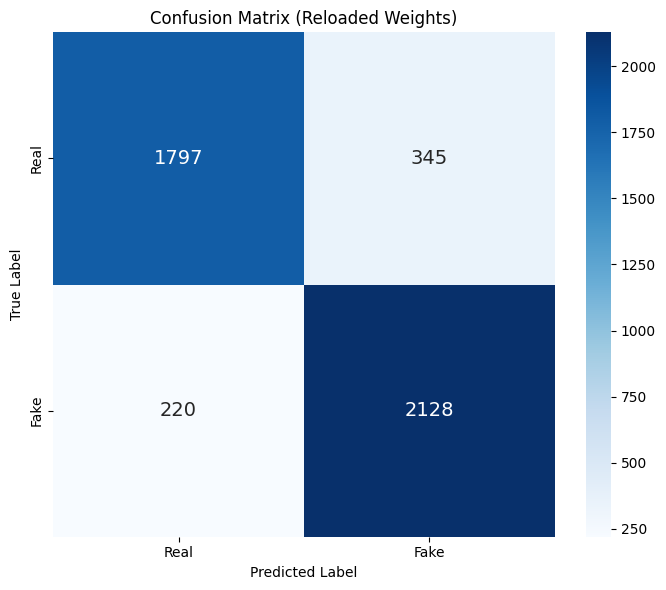

In [ ]:
# EVALUATE ON TEST SET
X_test_tok = tokenizer(
    X_test.tolist(),
    add_special_tokens=True,
    max_length=MAX_LEN,
    truncation=True,
    padding='max_length',
    return_tensors='tf'
)

probs = model.predict(dict(X_test_tok), batch_size=32).flatten()
preds = (probs >= THRESHOLD).astype(int)
y_true = np.array(Y_test).flatten()

print("\nClassification Report (Test):")
print(classification_report(y_true, preds, target_names=['Real (0)', 'Fake (1)']))

cm = confusion_matrix(y_true, preds)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real','Fake'], yticklabels=['Real','Fake'],
            annot_kws={"size":14})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Reloaded Weights)")
plt.tight_layout()
plt.show()

In [ ]:
# GRADIO APP
!pip install gradio -q
import gradio as gr

def predict_fake_news(text):
    cleaned = clean_text(text)
    enc = tokenizer(
        cleaned, max_length=MAX_LEN, truncation=True,
        padding='max_length', return_tensors='tf'
    )
    score = model.predict(dict(enc), verbose=0)[0][0]
    return {'FAKE': float(score), 'REAL': float(1.0 - score)}

examples = [
    ["BREAKING: A source close to the White House claims the president is secretly a lizard person."],
    ["The S&P 500 closed up 0.5% after the Fed announcement."],
    ["You will be SHOCKED to learn this one weird trick to lose weight."]
]

gr.Interface(
    fn=predict_fake_news,
    inputs=gr.Textbox(lines=8, placeholder="Paste a news article..."),
    outputs=gr.Label(num_top_classes=2, label="Verdict"),
    title=" BERT Fake News Detector (Weights Reload)",
    description="Loads the BERT model architecture and weights-only for inference.",
    examples=examples
).launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://76b7a2d6dc19c93a46.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://76b7a2d6dc19c93a46.gradio.live
